# Regression and Other Stories: Beauty and Teaching Quality

Hamermesh and Parker (2005) data on student evaluations of instructors’ beauty and teaching quality for several courses at the University of Texas. See Chapter 10 in Regression and Other Stories.

Hamermesh, D. S., and Parker, A. M. (2005). Beauty in the classroom: Instructors' pulchritude and putative pedagogical productivity. Economics of Education Review, 24:369-376.

----

#### Load packages

In [1]:
using DataFrames, StatsPlots, CSV, HTTP
using Distributions, Turing, MCMCChains, CategoricalArrays

#### Load data

In [2]:
data = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Beauty/data/beauty.csv"
beauty  = CSV.File(HTTP.get(data).body, delim=",", missingstring="NA") |> DataFrame
first(beauty , 6);

## Do more beautiful profs get higher evaluations?

#### Make a scatterplot of data

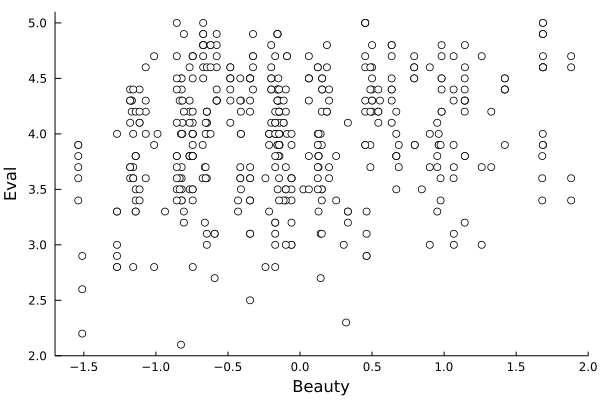

In [3]:
scatter(
    beauty.beauty,
    beauty.eval,
    color=:white,
    grid=false, legend=false,
    ylim=(2.0,5.1),xlim=(-1.7,2.0),
    xticks=-1.5:0.5:2.0, yticks=2.0:0.5:5.0,
    xlabel="Beauty", ylabel="Eval"
)

#### Fit a linear regression

In [4]:
@model function linear(b,e)
    σ ~ Exponential(10)
    α ~ Normal(0, 10)
    β ~ Normal(0, 10)
    μ = α .+ b * β
    e ~ MvNormal(μ, σ)
end
model_1 = linear(beauty.beauty, beauty.eval)
fit_1 = sample(model_1, NUTS(), 4000)
summarystats(fit_1)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    4.0107    0.0257     0.0004    0.0003   7005.6083    0.9999    ⋯
           β    0.1329    0.0315     0.0005    0.0004   6256.8274    0.9999    ⋯
           σ    0.5464    0.0182     0.0003    0.0002   5898.6906    0.9998    ⋯
                                                                1 column omitted


#### Make a scatterplot with regression lines

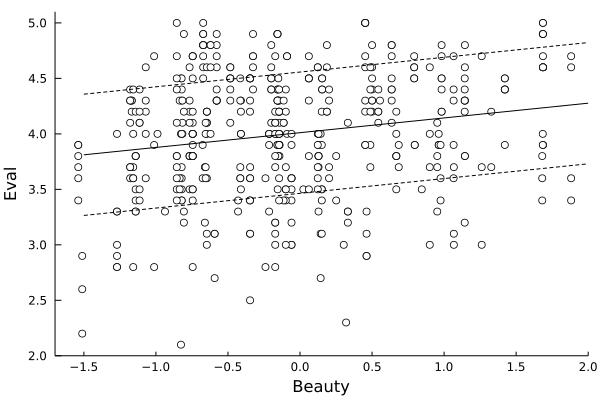

In [5]:
scatter(
    beauty.beauty,
    beauty.eval,
    color=:white,
    grid=false, legend=false,
    ylim=(2.0,5.1),xlim=(-1.7,2.0),
    xticks=-1.5:0.5:2.0, yticks=2.0:0.5:5.0,
    xlabel="Beauty", ylabel="Eval"
)
coefs = get(fit_1, [:α, :β, :σ])
plot!(-1.5:0.1:2.0, x->mean(coefs.α) + x * mean(coefs.β),color=:black)
sty = Dict(:color=>:black, :linestyle=>:dash)    
plot!(-1.5:0.1:2.0, x->mean(coefs.α) + x * mean(coefs.β) + mean(coefs.σ) ;sty...)
plot!(-1.5:0.1:2.0, x->mean(coefs.α) + x * mean(coefs.β) - mean(coefs.σ) ;sty...)

## Do things differ for male and female profs?

#### Parallel regression lines

In [6]:
@model function linear_2(b, f, e)
    σ ~ Exponential(10)
    α ~ Normal(0, 10)
    βb ~ Normal(0, 10)
    βf ~ Normal(0,10)
    μ = α .+ b * βb .+ f * βf
    e ~ MvNormal(μ, σ)
end
model_2 = linear_2(beauty.beauty, beauty.female, beauty.eval)
fit_2 = sample(model_2, NUTS(), 4000)
summarystats(fit_2)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    4.0943    0.0330     0.0005    0.0006   2921.0255    0.9998    ⋯
          βb    0.1495    0.0317     0.0005    0.0007   3665.4600    1.0011    ⋯
          βf   -0.1971    0.0510     0.0008    0.0008   3019.6073    1.0000    ⋯
           σ    0.5389    0.0177     0.0003    0.0002   3576.8840    0.9998    ⋯
                                                                1 column omitted


In [7]:
coefs2 = get(fit_2, [:α, :βb, :βf, :σ]);

#### Make several subplots

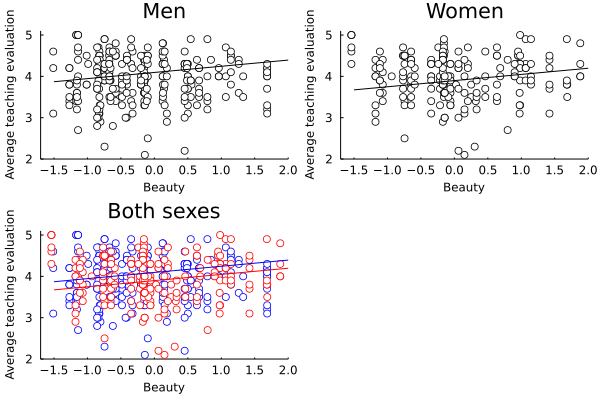

In [8]:
sty=Dict(
    :color=>:white,
    :grid=>false, 
    :legend=>false,
    :ylim=>(2.0,5.1),
    :xlim=>(-1.7,2.0),
    :xticks=>-1.5:0.5:2.0, 
    :yticks=>2.0:1:5.0,
    :xlabel=>"Beauty",
    :ylabel=>"Average teaching evaluation",
    :labelfontsize=>8
)
p1 = scatter(beauty.beauty[beauty.female.==0], beauty.eval, title="Men" ; sty...)
plot!(-1.5:0.1:2.0, x->mean(coefs2.α) + x * mean(coefs2.βb),color=:black)

p2 = scatter(beauty.beauty[beauty.female.==1],beauty.eval,title="Women" ; sty...)
plot!(-1.5:0.1:2.0, x->mean(coefs2.α) + x * mean(coefs2.βb) + mean(coefs2.βf),color=:black)

p3 = scatter(beauty.beauty[beauty.female.==0],beauty.eval, markerstrokecolor=:blue,title="Both sexes" ;sty...)
scatter!(beauty.beauty[beauty.female.==1],beauty.eval, color=:white, markerstrokecolor=:red)
plot!(-1.5:0.1:2.0, x->mean(coefs2.α) + x * mean(coefs2.βb),color=:blue)
plot!(-1.5:0.1:2.0, x->mean(coefs2.α) + x * mean(coefs2.βb) + mean(coefs2.βf),color=:red)

l= @layout [ a b ; c _ ]
plot(p1,p2,p3, layout=l)

## Do things differ for male and female profs?

#### Non-parallel regression lines

In [9]:
@model function linear_interact(b, f, e)
    σ ~ Exponential(10)
    α ~ Normal(0, 10)
    βb ~ Normal(0, 10)
    βf ~ Normal(0,10)
    βi ~ Normal(0,10)
    μ = α .+ b * βb .+ f * βf .+ b.*f*βi
    e ~ MvNormal(μ, σ)
end
model_3 = linear_interact(beauty.beauty, beauty.female, beauty.eval)
fit_3 = sample(model_3, NUTS(), 4000)
summarystats(fit_3)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    4.1038    0.0340     0.0005    0.0006   3096.3788    1.0006    ⋯
          βb    0.2003    0.0432     0.0007    0.0009   2801.1638    0.9998    ⋯
          βf   -0.2054    0.0519     0.0008    0.0009   2854.1475    1.0001    ⋯
          βi   -0.1126    0.0633     0.0010    0.0014   3398.0595    0.9998    ⋯
           σ    0.5375    0.0180     0.0003    0.0003   3566.6444    0.9999    ⋯
                                                                1 column omitted


In [10]:
coefs3 = get(fit_3, [:α, :βb, :βf, :βi, :σ]);

#### Make two subplots

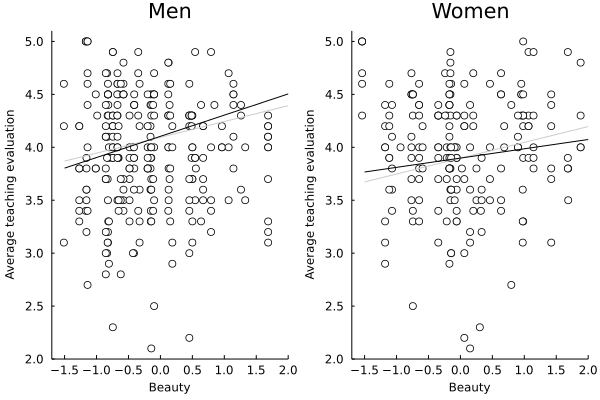

In [11]:
sty[:yticks] = 2.0:0.5:5.0
p1 = scatter(beauty.beauty[beauty.female.==0], beauty.eval, title="Men" ; sty...)
plot!(-1.5:0.1:2.0, x->mean(coefs2.α) + x * mean(coefs2.βb),color=:gray80)
plot!(-1.5:0.1:2.0, x->mean(coefs3.α) + x * mean(coefs3.βb),color=:black)

p2 = scatter(beauty.beauty[beauty.female.==1], beauty.eval, title="Women" ; sty...)
plot!(-1.5:0.1:2.0, 
    x->mean(coefs2.α) + x * mean(coefs2.βb) + 1 * mean(coefs2.βf),
    color=:gray80)
plot!(-1.5:0.1:2.0, 
    x->mean(coefs3.α) + x * mean(coefs3.βb) + 1 * mean(coefs3.βf) + 1 * x * mean(coefs3.βi),
    color=:black)

plot(p1,p2)

## More models

#### Add age

In [12]:
@model function linear_4(b, f, a, e)
    σ ~ Exponential(10)
    α ~ Normal(0, 10)
    βb ~ Normal(0, 10)
    βf ~ Normal(0,10)
    βa ~ Normal(0,10)
    μ = α .+ b * βb .+ f * βf .+ a * βa
    e ~ MvNormal(μ, σ)
end
model_4 = linear_4(
    beauty.beauty, beauty.female, beauty.age, beauty.eval
)
fit_4 = sample(model_4, NUTS(), 4000)
summarystats(fit_4)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    4.2284    0.1420     0.0022    0.0028   2417.9429    0.9998    ⋯
          βa   -0.0027    0.0028     0.0000    0.0001   2458.8479    0.9998    ⋯
          βb    0.1394    0.0330     0.0005    0.0006   2797.2034    0.9998    ⋯
          βf   -0.2117    0.0521     0.0008    0.0009   3108.3677    1.0002    ⋯
           σ    0.5382    0.0175     0.0003    0.0003   3236.2766    1.0014    ⋯
                                                                1 column omitted


#### Add minority

In [13]:
@model function linear_5(b, f, m, e)
    σ ~ Exponential(10)
    α ~ Normal(0, 10)
    βb ~ Normal(0, 10)
    βf ~ Normal(0,10)
    βm ~ Normal(0,10)
    μ = α .+ b * βb .+ f * βf .+ m * βm
    e ~ MvNormal(μ, σ)
end
model_5 = linear_5(
    beauty.beauty, beauty.female, beauty.minority, beauty.eval
)
fit_5 = sample(model_5, NUTS(), 4000)
summarystats(fit_5)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    4.1067    0.0348     0.0005    0.0006   3374.0108    0.9998    ⋯
          βb    0.1494    0.0322     0.0005    0.0004   4370.8048    0.9998    ⋯
          βf   -0.1908    0.0523     0.0008    0.0010   3461.9533    0.9999    ⋯
          βm   -0.1034    0.0738     0.0012    0.0011   4347.1771    0.9999    ⋯
           σ    0.5388    0.0175     0.0003    0.0002   4500.8456    0.9998    ⋯
                                                                1 column omitted


#### Add nonenglish

In [14]:
@model function linear_6(b, f, n, e)
    σ ~ Exponential(10)
    α ~ Normal(0, 10)
    βb ~ Normal(0, 10)
    βf ~ Normal(0,10)
    βn ~ Normal(0,10)
    μ = α .+ b * βb .+ f * βf .+ n * βn
    e ~ MvNormal(μ, σ)
end
model_6 = linear_6(
    beauty.beauty, beauty.female, beauty.nonenglish, beauty.eval
)
fit_6 = sample(model_6, NUTS(), 4000)
summarystats(fit_6)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    4.1143    0.0341     0.0005    0.0006   3378.0159    0.9999    ⋯
          βb    0.1488    0.0320     0.0005    0.0005   4050.5691    0.9999    ⋯
          βf   -0.1959    0.0515     0.0008    0.0008   3515.9432    1.0000    ⋯
          βn   -0.3318    0.1030     0.0016    0.0014   4922.6471    0.9998    ⋯
           σ    0.5333    0.0176     0.0003    0.0002   4218.3269    0.9998    ⋯
                                                                1 column omitted


#### Add nonenglish and lower

In [15]:
@model function linear_7(b, f, n, l, e)
    σ ~ Exponential(10)
    α ~ Normal(0, 10)
    βb ~ Normal(0, 10)
    βf ~ Normal(0,10)
    βn ~ Normal(0,10)
    βl ~ Normal(0,10)
    μ = α .+ b * βb .+ f * βf .+ n * βn .+ l * βl
    e ~ MvNormal(μ, σ)
end
model_7 = linear_7(
    beauty.beauty, beauty.female, beauty.nonenglish, beauty.lower, beauty.eval
)
fit_7 = sample(model_7, NUTS(), 4000)
summarystats(fit_7)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    4.0791    0.0395     0.0006    0.0006   3666.2536    0.9998    ⋯
          βb    0.1475    0.0320     0.0005    0.0004   5291.2079    0.9999    ⋯
          βf   -0.1921    0.0491     0.0008    0.0007   4847.4812    0.9998    ⋯
          βl    0.0937    0.0540     0.0009    0.0008   4405.5165    0.9998    ⋯
          βn   -0.3086    0.1057     0.0017    0.0013   4924.6866    0.9998    ⋯
           σ    0.5321    0.0182     0.0003    0.0002   6060.3227    0.9999    ⋯
                                                                1 column omitted


## Simple model with course indicators

#### Include course indicators in a regression

Not sure how to map index to original notebook one-to-one, need to check what stan_glm does.

In [16]:
@model function linear_8(b, c, e)
    σ ~ Exponential(10)
    α ~ Normal(0, 10)
    βb ~ Normal(0, 10)

    n_course = unique(c)
    τ_course ~ filldist( Normal(0, 1), length(n_course))
    
    μ = α .+ b * βb .+ τ_course[c]
    e ~ MvNormal(μ, σ)
end
model_8 = linear_8(beauty.beauty, 
    beauty.course_id.+1, # one added because idx from 1, but array starts at 0
    beauty.eval)
fit_8 = sample(model_8, NUTS(), 4000)
summarystats(fit_8)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\pwMQO\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:41


Summary Statistics
    parameters      mean       std   naive_se      mcse         ess      rhat  ⋯
        Symbol   Float64   Float64    Float64   Float64     Float64   Float64  ⋯

             α    4.0007    0.1858     0.0029    0.0084    466.1423    1.0006  ⋯
            βb    0.1358    0.0347     0.0005    0.0004   6090.1456    1.0000  ⋯
             σ    0.5257    0.0182     0.0003    0.0002   6013.5517    1.0003  ⋯
   τ_course[1]    0.0298    0.1879     0.0030    0.0085    480.1414    1.0007  ⋯
   τ_course[2]    0.3780    0.2889     0.0046    0.0094    993.0926    1.0007  ⋯
   τ_course[3]    0.3964    0.3853     0.0061    0.0091   1991.2905    0.9999  ⋯
   τ_course[4]   -0.1365    0.2543     0.0040    0.0088    825.5871    1.0000  ⋯
   τ_course[5]   -0.1686    0.2160     0.0034    0.0089    607.5079    1.0002  ⋯
   τ_course[6]    0.0481    0.3008     0.0048    0.0094   1034.4918    1.0004  ⋯
   τ_course[7]   -0.1013    0.2746     0.0043    0.0085    975.2503    1.0002  ⋯
   τ_cou